In [2]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange, uniform
from scipy.stats import norm
import math

In [4]:
def Objective_Function2(variance=10,lengthscale=1.2,M=40, seed=1):

  np.random.seed(seed) 
  temp = float(np.random.uniform(low=-2, high=2, size=1))

  X_total=[]


  for n in range(M*M):
    i = int(n/M)
    j = n%M
    X_total.append([i*0.15,j*0.15])


  X_total = np. array(X_total)


  X_sample=np.array([[5.4,3.8]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=2,variance=variance,lengthscale=lengthscale)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y_total = m.posterior_samples_f(X_total,size=1).reshape(-1,1)
  Y_total = Y_total.reshape(M,M)

  return X_total, Y_total

def turn(ind):
  i = int(ind/40)
  j = int(ind%40)

  return i,j

def init(X_total, Y_total,seed=1):
  
  np.random.seed(seed)

  X_sample = []
  Y_sample = []

  x1_index_holder = [3,5,10,12,18,20]    #[3,5,10,12,18,20,24,28,30,35,35]
  x2_index_holder =  [38,20,16,4,39,28]    # [38,20,16,4,39,28,30,35,29,15]

  for i in range(len(x1_index_holder)):
    x1_index = x1_index_holder[i]           #int(np.random.randint(40, size=1))
    x2_index =  x2_index_holder[i]           #int(np.random.randint(40, size=1))


    X_temp = X_total[x1_index*40+x2_index]
    Y_temp = Y_total[x1_index,x2_index]
    X_sample.append(X_temp)
    Y_sample.append(Y_temp)

  return np.array(X_sample),np.array(Y_sample)


def EI(mean,var,y_max):

  z = (mean - y_max)/np.sqrt(var)        
  out=(mean - y_max) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out 

def findmax(mean,var,fstar):
   pdf_fmax = 1/(np.sqrt(2*np.pi*var))*np.exp(-(fstar-mean)**2/(2*var))

   return pdf_fmax
 

def MSE(mean,var,fstar):
    
  gamma = (fstar-mean)/np.sqrt(var)  
  
  out = (gamma*norm.pdf(gamma))/(2*norm.cdf(gamma))-np.log(norm.cdf(gamma))

  return out 

def over_max(mean,var,fstar):
  z = (fstar - mean)/np.sqrt(var)   
  below_max = norm.cdf(z)
  out = 1 - below_max
  
  return out 


# def findmax(mean,var,fstar):
#    z = (fstar - mean)/np.sqrt(var)  
#    out = norm.pdf(z)   

#    return out
    
  


def normal_BO(X_total,Y_total,acq,fstar, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
  
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=10,lengthscale=1.2)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    #m.optimize()

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    #print(mean[mean>fstar])

    if acq == 'ei':
      acq_value = EI(mean,var,Y_max_holder[-1])
      
    elif acq=='find_max':
      acq_value = findmax(mean,var,fstar)
    
    elif acq == 'mes':
      acq_value = MSE(mean,var,fstar)
      
    elif acq == 'over_max':
      acq_value = over_max(mean,var,fstar)
      
    elif acq == 'new ei':
      part1 = EI(mean,var,Y_max_holder[-1])
      part2 = EI(mean,var,fstar)
      acq_value = part1-part2

    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder



def my_new_BO(X_total,Y_total, fstar,seed = 1,variance=10,lengthscale=1.2): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
    
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed=seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=variance,lengthscale=lengthscale)   #change lengthscale if needed!!!!!!!!!
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    #m.optimize()

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X_total.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        X_current_0 = X_total[i][0]
        X0_lower = max(0.0,X_current_0-10*0.15)
        X0_upper = min(5.85,X_current_0+10*0.15)
        X0_range = np.arange(X0_lower,X0_upper,0.15)

        X_current_1 = X_total[i][1]
        X1_lower = max(0.0,X_current_1-10*0.15)
        X1_upper = min(5.85,X_current_1+10*0.15)
        X1_range = np.arange(X1_lower,X1_upper,0.15)

        X_near = []

        for x0 in X0_range:
          for x1 in X1_range:
            X_near.append([x0,x1])
        X_near = np.array(X_near)



        kernel = GPy.kern.RBF(input_dim=2,variance=variance,lengthscale=lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,2),Y_sample_temp.reshape(-1,1),kernel)
        m_temp.Gaussian_noise.variance.fix(0.0)

        mean_temp,var_temp = m_temp.predict(X_near,include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.min(PnI)
        part2_total[i] = part2

    acq_value = part1_total*part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder



def my_new_BO2(X_total,Y_total, fstar, seed = 1, variance=10, lengthscale=1.2): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
    
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed=seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=variance,lengthscale=lengthscale)   #change lengthscale if needed!!!!!!!!!
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    #m.optimize()

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X_total.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        X_current_0 = X_total[i][0]
        X0_lower = max(0.0,X_current_0-10*0.15)
        X0_upper = min(5.85,X_current_0+10*0.15)
        X0_range = np.arange(X0_lower,X0_upper,0.15)

        X_current_1 = X_total[i][1]
        X1_lower = max(0.0,X_current_1-10*0.15)
        X1_upper = min(5.85,X_current_1+10*0.15)
        X1_range = np.arange(X1_lower,X1_upper,0.15)

        X_near = []

        for x0 in X0_range:
          for x1 in X1_range:
            X_near.append([x0,x1])
        X_near = np.array(X_near)



        kernel = GPy.kern.RBF(input_dim=2,variance=variance,lengthscale=lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,2),Y_sample_temp.reshape(-1,1),kernel)
        m_temp.Gaussian_noise.variance.fix(0.0)

        mean_temp,var_temp = m_temp.predict(X_near,include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.prod(PnI**(1/25))
        part2_total[i] = part2

    acq_value = part1_total*part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [7]:
def my_new_BO_full_search(X_total,Y_total,acq, fstar,seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
    
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed=seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    print(n)
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=10,lengthscale=1.2)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    #m.optimize()

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X_total.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        X_current_0 = X_total[i][0]
        X0_lower = 0.0
        X0_upper = 5.85
        X0_range = np.arange(X0_lower,X0_upper,0.15)

        X_current_1 = X_total[i][1]
        X1_lower = 0.0
        X1_upper = 5.85
        X1_range = np.arange(X1_lower,X1_upper,0.15)

        X_near = []

        for x0 in X0_range:
          for x1 in X1_range:
            X_near.append([x0,x1])
        X_near = np.array(X_near)



        kernel = GPy.kern.RBF(input_dim=2,variance=10,lengthscale=1.2)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,2),Y_sample_temp.reshape(-1,1),kernel)
        m_temp.Gaussian_noise.variance.fix(0.0)

        mean_temp,var_temp = m_temp.predict(X_near,include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.min(PnI)
        part2_total[i] = part2

    acq_value = part1_total*part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

# ERM

In [3]:
def trans (Y_sample,fstar):
  value = np.sqrt(2*(fstar-Y_sample))

  return value



def paper_BO(X_total,Y_total,acquisition, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar = np.max(Y_total)
  print('optimum is ', fstar)

  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  normal_BO = True

  for n in range(total_round):
    #train the GP model for X and centrailised Y

    if normal_BO:
    
      kernel = GPy.kern.RBF(input_dim=2,variance=m_var,lengthscale=m_lengthscale)
      m = GPy.models.GPRegression(X_sample.reshape(-1,2),Y_sample.reshape(-1,1),kernel)
      m.Gaussian_noise.variance.fix(0.0)
      #m.optimize()
      
      m_var = m.rbf.variance
      m_lengthscale = m.rbf.lengthscale


      #find the X that can maximize the acqusition function:
      mean,var = m.predict(X_total.reshape(-1,2),include_likelihood=False)

      if acquisition == 'ei':
        acq_value = EI(mean,var,Y_max_holder[-1])
      elif acquisition == 'pi':
        z = (Y_max_holder[-1]-mean)/np.sqrt(var)
        PnI = norm.cdf(z)
        acq_value = 1-PnI 
      elif acquisition == 'new ei':
        part1 = EI(mean,var,Y_max_holder[-1])
        part2 = EI(mean,var,fstar)
        acq_value = part1-part2

      #calculate the ucb:
      beta_t = np.log(Y_sample.shape [0])/2
      output = mean + np.sqrt(beta_t) * np.sqrt(var)
      normal_BO = all(output<fstar)

      print(normal_BO)

      index = np.argmax(acq_value)
      X_chosen = X_total[index]
      i_index,j_index = turn(index)
      Y_chosen = Y_total[i_index,j_index]

      X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
      Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

      Y_max= np.max(Y_sample)
      Y_max_holder.append(Y_max)

    else:
      Y_transfromed = trans (Y_sample,fstar)

      #train the model:
      kernel = GPy.kern.RBF(input_dim=2,variance=1,lengthscale=2)
      m = GPy.models.GPRegression(X_sample.reshape(-1,2),Y_transfromed.reshape(-1,1),kernel)
      m.Gaussian_noise.variance.fix(0.0)
      m.optimize()



      mean,var = m.predict(X_total.reshape(-1,2),include_likelihood=False)
      var2 = np.maximum(var, 1e-9 + 0 * var)
      z = ( fstar-mean)/np.sqrt(var2)        
      acq_value=(fstar-mean) * (norm.cdf(z)) + np.sqrt(var2) * norm.pdf(z)

      index = np.argmin(acq_value)
      X_chosen = X_total[index]
      i_index,j_index = turn(index)
      Y_chosen = Y_total[i_index,j_index]

      X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
      Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

      Y_max= np.max(Y_sample)
      Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar - Y_max_holder


  return regret_holder

# run experiment

In [12]:
regret_holder11 = []
regret_holder22 = []
regret_holder33 = []


N = 25

for i in range(N):
  X_total, Y_total = Objective_Function2(variance=10,lengthscale=1.2,seed=i)
  fstar = np.max(Y_total)
  print('optimal: ',fstar)

  regret_temp1 = normal_BO(X_total,Y_total,'new ei',fstar,seed = i)
  regret_holder11.append(regret_temp1)
  
  regret_temp2 = normal_BO(X_total,Y_total,'ei',fstar,seed = i)
  regret_holder22.append(regret_temp2)
  
  regret_temp3 = normal_BO(X_total,Y_total,'mes',fstar,seed = i)
  regret_holder33.append(regret_temp3)

optimal:  8.727577580588184
optimal:  8.54521814836547
optimal:  9.599403924100287
optimal:  9.245604705958938
optimal:  4.690464400715211
optimal:  4.557852136204864
optimal:  6.946430742318223
optimal:  9.414359329489269
optimal:  8.812259996309638
optimal:  10.93212081830334
optimal:  8.329668074946985
optimal:  5.2762625944765915
optimal:  7.542818617196383
optimal:  4.570933852837657
optimal:  7.043087317601986
optimal:  8.98914497387836
optimal:  3.7392942774001674
optimal:  6.261578840090775
optimal:  1.2668199965503306
optimal:  7.039994137960573
optimal:  8.053622404479796
optimal:  6.348798373484226
optimal:  8.490096588496172
optimal:  7.303018331191995
optimal:  9.639679483925663


In [11]:
regret_holder44 = []
regret_holder55 = []


N = 25

for i in range(N):
  X_total, Y_total = Objective_Function2(variance=10,lengthscale=1.2,seed=i+25)
  fstar = np.max(Y_total)
  print('optimal: ',fstar)
  
  regret_temp4 = my_new_BO(X_total,Y_total, fstar,seed = i+25,lengthscale=1.2)
  regret_holder44.append(regret_temp4)
  
  regret_temp5 = my_new_BO2(X_total,Y_total, fstar,seed = i+25,lengthscale=1.2)
  regret_holder55.append(regret_temp5)

optimal:  8.82325926622428
optimal:  4.721420523368505
optimal:  3.6231609023603
optimal:  6.30788925495041
optimal:  5.467136358034426
optimal:  6.772956204767523
optimal:  6.862102432225318
optimal:  8.74514067226271
optimal:  7.083145726732453
optimal:  4.010795689365967
optimal:  5.447592369379553
optimal:  6.1559765292273925
optimal:  7.013139325760688
optimal:  5.589517214571783
optimal:  6.8999764352862005
optimal:  6.063541111831253
optimal:  5.604276609835065
optimal:  8.453084488247704
optimal:  5.16690954009069
optimal:  7.049243751732127
optimal:  8.450911045021764
optimal:  8.93854606929712
optimal:  4.132810310705614
optimal:  7.082293979921761
optimal:  4.953719155240104


In [9]:
regret_holder1 = []
regret_holder2 = []
regret_holder3 = []
regret_holder4 = []
regret_holder5 = []

N = 25

for i in range(N):
  X_total, Y_total = Objective_Function2(variance=10,lengthscale=1.2,seed=i)
  fstar = np.max(Y_total)
  print('optimal: ',fstar)



  regret_temp1 = normal_BO(X_total,Y_total,'new ei',fstar,seed = i)
  regret_holder1.append(regret_temp1)
  
  regret_temp2 = normal_BO(X_total,Y_total,'ei',fstar,seed = i)
  regret_holder2.append(regret_temp2)
  
  regret_temp3 = normal_BO(X_total,Y_total,'mes',fstar,seed = i)
  regret_holder3.append(regret_temp3)
  
  regret_temp4 = my_new_BO(X_total,Y_total, fstar,seed = i,lengthscale=1.2)
  regret_holder4.append(regret_temp4)
  
  regret_temp5 = my_new_BO2(X_total,Y_total, fstar,seed = i,lengthscale=1.2)
  regret_holder5.append(regret_temp5)

optimal:  8.727577580588184
optimal:  8.54521814836547
optimal:  9.599403924100287
optimal:  9.245604705958938
optimal:  4.690464400715211
optimal:  4.557852136204864
optimal:  6.946430742318223
optimal:  9.414359329489269
optimal:  8.812259996309638
optimal:  10.93212081830334
optimal:  8.329668074946985
optimal:  5.2762625944765915
optimal:  7.542818617196383
optimal:  4.570933852837657
optimal:  7.043087317601986
optimal:  8.98914497387836
optimal:  3.7392942774001674
optimal:  6.261578840090775
optimal:  1.2668199965503306
optimal:  7.039994137960573
optimal:  8.053622404479796
optimal:  6.348798373484226
optimal:  8.490096588496172
optimal:  7.303018331191995
optimal:  9.639679483925663


In [13]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

regret_holder11 = np.array(regret_holder11)
regret_holder22 = np.array(regret_holder22)
regret_holder33 = np.array(regret_holder33)
regret_holder44 = np.array(regret_holder44)
regret_holder55 = np.array(regret_holder55)

In [22]:
regret_holder_tei = np.concatenate((regret_holder1,regret_holder11),axis=0)
regret_holder_ei = np.concatenate((regret_holder2,regret_holder22),axis=0)
regret_holder_mes = np.concatenate((regret_holder3,regret_holder33),axis=0)
regret_holder_po = np.concatenate((regret_holder4,regret_holder44),axis=0)
regret_holder_po2 = np.concatenate((regret_holder5,regret_holder55),axis=0)

logregret_holder_tei = np.log(regret_holder_tei)
logregret_holder_ei = np.log(regret_holder_ei)
logregret_holder_mes = np.log(regret_holder_mes)
logregret_holder_po = np.log(regret_holder_po)
logregret_holder_po2 = np.log(regret_holder_po2)

logregret_holder_tei[logregret_holder_tei == float('-inf')] = -8
logregret_holder_ei[logregret_holder_ei == float('-inf')] = -8
logregret_holder_mes[logregret_holder_mes == float('-inf')] = -8
logregret_holder_po[logregret_holder_po == float('-inf')] = -8
logregret_holder_po2[logregret_holder_po2 == float('-inf')] = -8



 /tmp/ipykernel_157653/2476964686.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/2476964686.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/2476964686.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/2476964686.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/2476964686.py:11: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


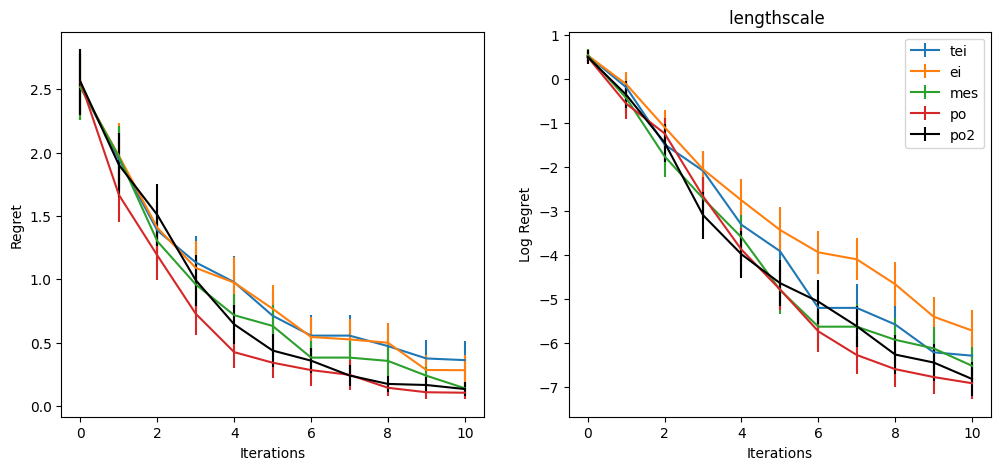

In [23]:
N = 50
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder_tei,axis=0),np.std(regret_holder_tei,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder_ei,axis=0),np.std(regret_holder_ei,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder_mes,axis=0),np.std(regret_holder_mes,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder_po,axis=0),np.std(regret_holder_po,axis=0)/np.sqrt(N),label='po')
ax.errorbar(myxaxis,np.mean(regret_holder_po2,axis=0),np.std(regret_holder_po2,axis=0)/np.sqrt(N),label='po2',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder_tei,axis=0),np.std(logregret_holder_tei,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder_ei,axis=0),np.std(logregret_holder_ei,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder_mes,axis=0),np.std(logregret_holder_mes,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder_po,axis=0),np.std(logregret_holder_po,axis=0)/np.sqrt(N),label='po')
ax2.errorbar(myxaxis,np.mean(logregret_holder_po2,axis=0),np.std(logregret_holder_po2,axis=0)/np.sqrt(N),label='po2',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.title('lengthscale ')
plt.legend()

 /tmp/ipykernel_157653/711565964.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/711565964.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/711565964.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/711565964.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157653/711565964.py:11: RuntimeWarning:divide by zero encountered in log
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


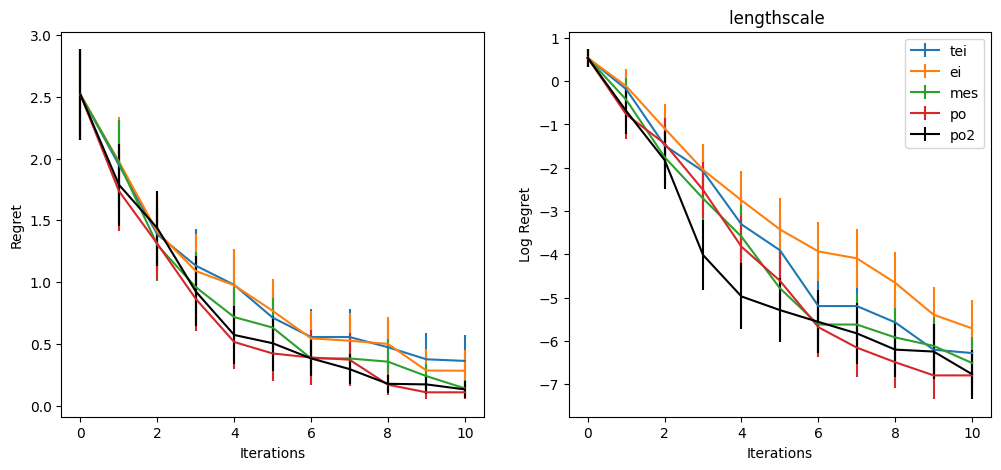

In [10]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)
logregret_holder5 = np.log(regret_holder5)


logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8
logregret_holder4[logregret_holder4 == float('-inf')] = -8
logregret_holder5[logregret_holder5 == float('-inf')] = -8

N = 25
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='po')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='po2',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='po')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='po2',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.title('lengthscale ')
plt.legend()

 /tmp/ipykernel_33177/2962516263.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_33177/2962516263.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_33177/2962516263.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_33177/2962516263.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_33177/2962516263.py:11: RuntimeWarning:divide by zero encountered in log
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


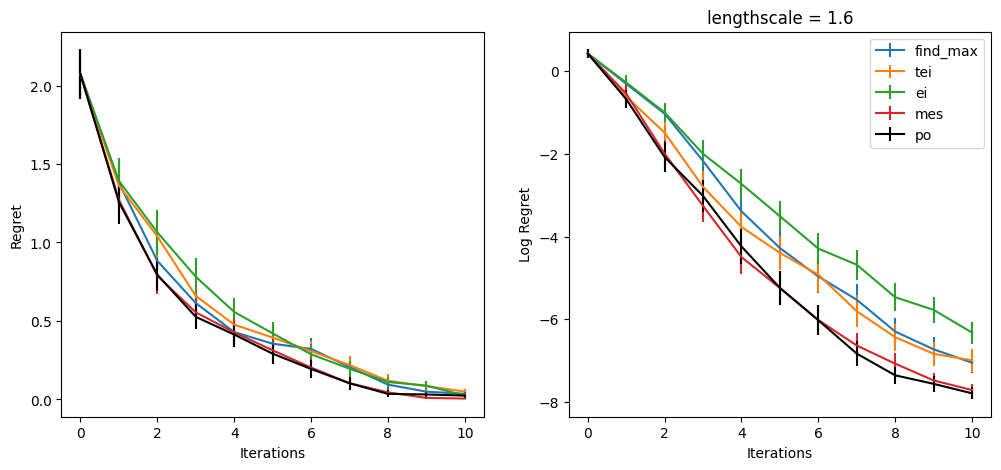

In [10]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)
logregret_holder5 = np.log(regret_holder5)


logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8
logregret_holder4[logregret_holder4 == float('-inf')] = -8
logregret_holder5[logregret_holder5 == float('-inf')] = -8

N = 75
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='find_max')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='find_max')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.title('lengthscale = 1.6')
plt.legend()

 /tmp/ipykernel_51234/3514095310.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51234/3514095310.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51234/3514095310.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51234/3514095310.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51234/3514095310.py:11: RuntimeWarning:divide by zero encountered in log
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


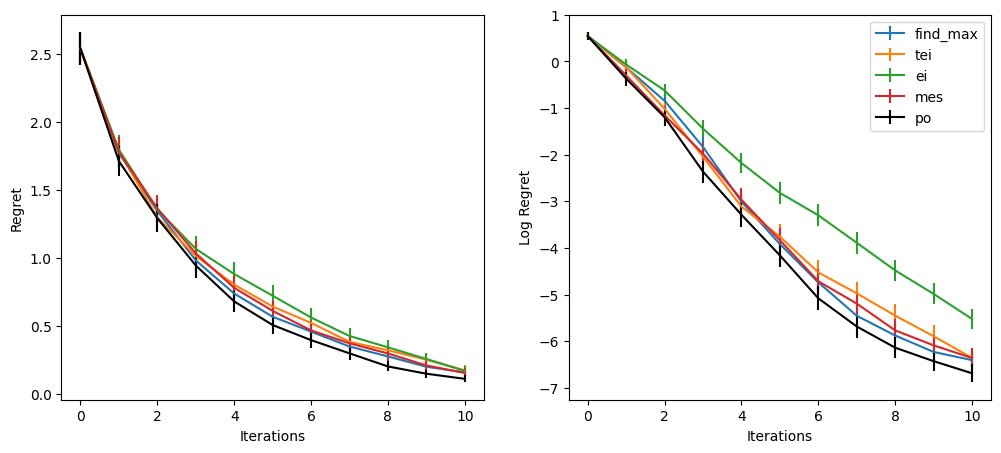

In [10]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)
logregret_holder5 = np.log(regret_holder5)


logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8
logregret_holder4[logregret_holder4 == float('-inf')] = -8
logregret_holder5[logregret_holder5 == float('-inf')] = -8

N = 200
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='find_max')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='find_max')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

In [7]:
regret_holder1 = np.array(regret_holder1)
np.savetxt('GP2d_f', regret_holder1, delimiter=',')

In [10]:
N = 5

for i in range(N):
  X_total, Y_total = Objective_Function2(variance=10,lengthscale=1.2,seed=i)
  fstar = np.max(Y_total)
  print('optimal: ',fstar)

  _,X_chosen_over_max = normal_BO(X_total,Y_total,'over_max',fstar,seed = i)
  _,X_chosen_mes = normal_BO(X_total,Y_total,'over_max',fstar,seed = i)
  
  print('#################################')
  print(X_chosen_over_max == X_chosen_mes)

optimal:  8.727577580588184
#################################
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
optimal:  8.54521814836547
#################################
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
optimal:  9.599403924100287
#################################
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ 

In [9]:
X_chosen_over_max

array([[0.45, 5.7 ],
       [0.75, 3.  ],
       [1.5 , 2.4 ],
       [1.8 , 0.6 ],
       [2.7 , 5.85],
       [3.  , 4.2 ],
       [3.6 , 4.5 ],
       [4.2 , 5.25],
       [4.5 , 4.35],
       [5.25, 2.25],
       [0.  , 3.9 ],
       [0.  , 3.75],
       [0.15, 4.05],
       [0.  , 4.05],
       [0.15, 3.9 ],
       [0.15, 3.9 ],
       [0.15, 3.9 ],
       [0.15, 3.9 ],
       [0.15, 3.9 ],
       [0.15, 3.9 ]])

In [8]:
X_chosen_over_max == X_chosen_mes

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
regret_holder1 = np.array(regret_holder1)
np.savetxt('GP2d_over_max', regret_holder1, delimiter=',')

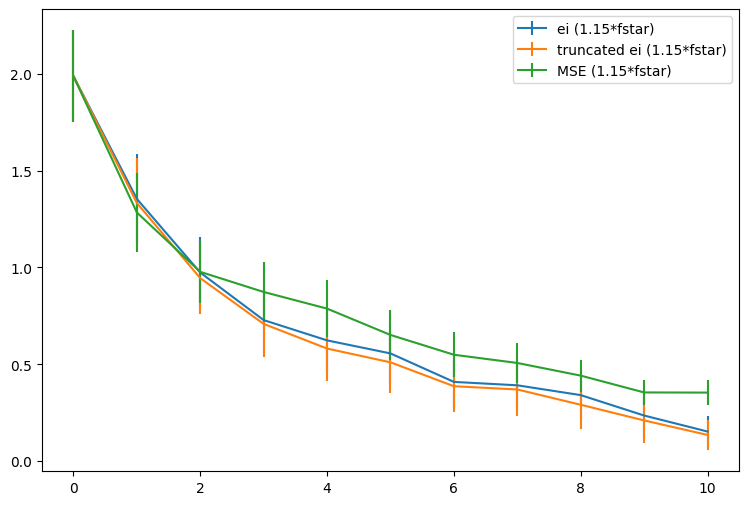

In [21]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder4 = np.array(regret_holder4)

myxaxis=range(regret_holder2.shape[1])
N =50 
plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei (1.15*fstar)')
plt.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='truncated ei (1.15*fstar)')
plt.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='MSE (1.15*fstar)')
plt.legend()

In [22]:
np.savetxt('GP2d_ei_1.15fstar', regret_holder1, delimiter=',')
np.savetxt('GP2d_new_ei_1.15fstar', regret_holder2, delimiter=',')
np.savetxt('GP2d_mse_1.15fstar', regret_holder4, delimiter=',')

In [30]:
# regret_holder1 = np.array(regret_holder1)
# regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
# regret_holder4 = np.array(regret_holder4)

# myxaxis=range(regret_holder2.shape[1])
# N =50 
# plt.figure(figsize=(9,6))
# plt.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei (0.85*fstar)')
# plt.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='truncated ei (0.85*fstar)')
# plt.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='new acq (0.85*fstar)')
# plt.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='MSE (0.85*fstar)')
# plt.legend()

In [ ]:
np.savetxt('GP2d_new_acq_1.15fstar', regret_holder3, delimiter=',')

In [25]:
np.savetxt('GP2d_ei_0.85fstar', regret_holder1, delimiter=',')
np.savetxt('GP2d_new_ei_0.85fstar', regret_holder2, delimiter=',')
np.savetxt('GP2d_mse_0.85fstar', regret_holder4, delimiter=',')

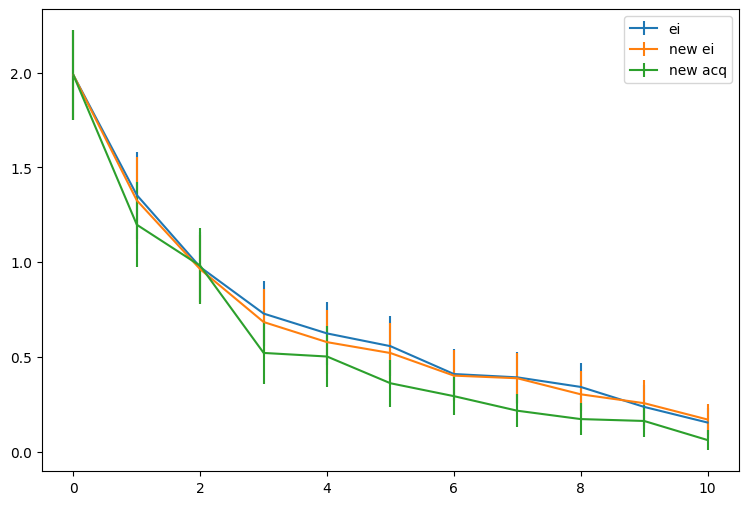

In [78]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)

myxaxis=range(regret_holder2.shape[1])
N =50 
plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
plt.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='new ei')
plt.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='new acq')
plt.legend()

 /tmp/ipykernel_51772/316233641.py:4: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51772/316233641.py:5: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_51772/316233641.py:6: RuntimeWarning:divide by zero encountered in log


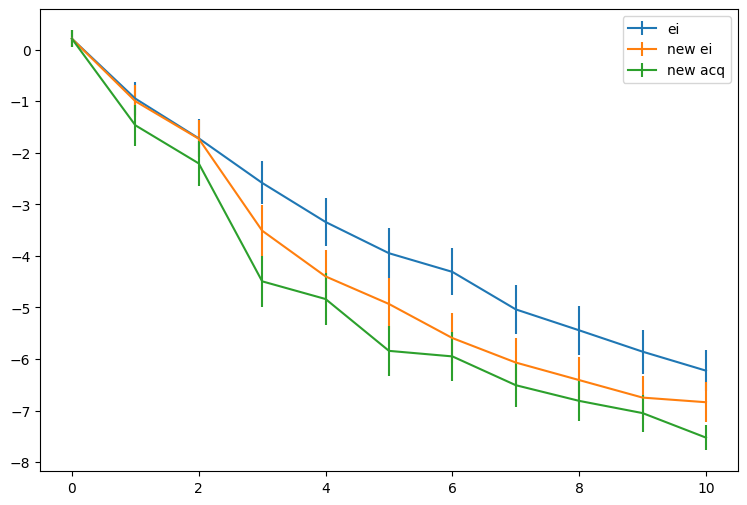

In [77]:
#myxaxis=range(a.shape[1])
N =50
myxaxis=range(regret_holder2.shape[1])
logregret_holder1_new = np.log(regret_holder1)
logregret_holder2_new = np.log(regret_holder2)
logregret_holder3_new = np.log(regret_holder3)


logregret_holder1_new[logregret_holder1_new == float('-inf')] = -8
logregret_holder2_new[logregret_holder2_new == float('-inf')] = -8
logregret_holder3_new[logregret_holder3_new == float('-inf')] = -8

plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(logregret_holder1_new,axis=0),np.std(logregret_holder1_new,axis=0)/np.sqrt(N),label='ei')
plt.errorbar(myxaxis,np.mean(logregret_holder2_new,axis=0),np.std(logregret_holder2_new,axis=0)/np.sqrt(N),label='new ei')
plt.errorbar(myxaxis,np.mean(logregret_holder3_new,axis=0),np.std(logregret_holder3_new,axis=0)/np.sqrt(N),label='new acq')

plt.legend()

In [79]:
np.savetxt('GP2d_ei', regret_holder1, delimiter=',')
np.savetxt('GP2d_new_ei', regret_holder2, delimiter=',')
np.savetxt('GP2d_new_acq', regret_holder3, delimiter=',')

In [67]:
regret_holder4 = []

N = 50

for i in range(N):
  X_total, Y_total = Objective_Function2(variance=10,lengthscale=1.2,seed=i)
  print('optimal: ',np.max(Y_total))

  regret_temp4 = paper_BO(X_total,Y_total,'ei',seed = i)
  regret_holder4.append(regret_temp4)


optimal:  8.727577580588184
optimum is  8.727577580588184
True
False


 /home/hanyang/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


optimal:  8.54521814836547
optimum is  8.54521814836547
False
optimal:  9.599403924100287
optimum is  9.599403924100287
True
False
optimal:  9.245604705958938
optimum is  9.245604705958938
True
True
True
True
True
True
True
True
True
True
optimal:  4.690464400715211
optimum is  4.690464400715211
False
optimal:  4.557852136204864
optimum is  4.557852136204864
False
optimal:  6.946430742318223
optimum is  6.946430742318223
False
optimal:  9.414359329489269
optimum is  9.414359329489269
False
optimal:  8.812259996309638
optimum is  8.812259996309638
False
optimal:  10.93212081830334
optimum is  10.93212081830334
False
optimal:  8.329668074946985
optimum is  8.329668074946985
True
True
True
True
True
True
False
optimal:  5.2762625944765915
optimum is  5.2762625944765915
False
optimal:  7.542818617196383
optimum is  7.542818617196383
False
optimal:  4.570933852837657
optimum is  4.570933852837657
False
optimal:  7.043087317601986
optimum is  7.043087317601986
True
True
True
False
optimal:  

In [50]:
np.savetxt('GP2d_erm', regret_holder4, delimiter=',')

### real function

In [51]:
def My_Objective_Function():

  X_total=[]

  for n in range(40*40):
    i = int(n/40)
    j = n%40
    X_total.append([i*0.15,j*0.15])


  X_total = (np. array(X_total))/10

  u = 1.2*X_total[:,0]-0.5
  v = 1.6*X_total[:,1]-0.5
  Y_total = 7.5*(1-(u**2 + v**2 - 0.3*np.cos(3*np.pi*u) - 0.3*np.cos(3*np.pi*v) ))-5.9

  Y_total = Y_total.reshape(40,40)

  return X_total, Y_total

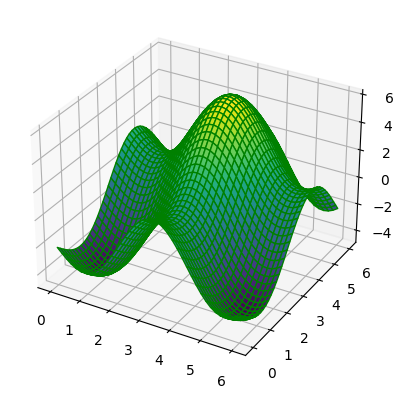

In [52]:
X_total, Y_total = My_Objective_Function()

X1 = np.linspace(0,6,40)
X2 = np.linspace(0,6,40)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total, cmap ='viridis', edgecolor ='green')

plt.show()

In [53]:
def My_Objective_Function_second():

  X_total=[]

  for n in range(40*40):
    i = int(n/40)
    j = n%40
    X_total.append([i*0.15,j*0.15])


  X_total = (np. array(X_total))

  u = X_total[:,0]-3
  v = (X_total[:,1]-3) /2
  
  Y_total = np.sin(u)*np.cos(v)*np.cos(u*v/2)+np.sin(u*v/5)

  Y_total = Y_total.reshape(40,40)

  return X_total, Y_total

In [54]:
def turn(ind):
  i = int(ind/40)
  j = int(ind%40)

  return i,j

def init(X_total, Y_total,seed=1):
  
  np.random.seed(seed)

  X_sample = []
  Y_sample = []

  for i in range(10):
    x1_index = int(np.random.randint(40, size=1))
    x2_index = int(np.random.randint(40, size=1))


    X_temp = X_total[x1_index*40+x2_index]
    Y_temp = Y_total[x1_index,x2_index]
    X_sample.append(X_temp)
    Y_sample.append(Y_temp)

  return np.array(X_sample),np.array(Y_sample)


def EI(mean,var,y_max):

  z = (mean - y_max)/np.sqrt(var)        
  out=(mean - y_max) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out 

def findmax(mean,var,fstar):
   pdf_fmax = 1/(np.sqrt(2*np.pi*var))*np.exp(-(fstar-mean)**2/(2*var))

   return pdf_fmax


def normal_BO(X_total,Y_total,acq, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar = np.max(Y_total)
  
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=10,lengthscale=1.2)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    m.optimize()

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    #print(mean[mean>fstar])

    if acq == 'ei':
      acq_value = EI(mean,var,Y_max_holder[-1])
    elif acq == 'new ei':
      part1 = EI(mean,var,Y_max_holder[-1])
      part2 = EI(mean,var,fstar)
      acq_value = part1-part2

    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar - Y_max_holder

  return regret_holder


def my_new_BO(X_total,Y_total,acq, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar = np.max(Y_total)
    
  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed=seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 
  
  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=2,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    m.optimize()
    
    m_var = m.rbf.variance
    m_lengthscale = m.rbf.lengthscale
    
    #print(m_lengthscale)

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X_total.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)
        
        multi = int(1.2*(m_lengthscale/0.15))

        X_current_0 = X_total[i][0]
        X0_lower = max(0.0,X_current_0-multi*0.15)
        X0_upper = min(5.85,X_current_0+multi*0.15)
        X0_range = np.arange(X0_lower,X0_upper,0.15)

        X_current_1 = X_total[i][1]
        X1_lower = max(0.0,X_current_1-multi*0.15)
        X1_upper = min(5.85,X_current_1+multi*0.15)
        X1_range = np.arange(X1_lower,X1_upper,0.15)

        X_near = []

        for x0 in X0_range:
          for x1 in X1_range:
            X_near.append([x0,x1])
        X_near = np.array(X_near)



        kernel = GPy.kern.RBF(input_dim=2,variance=m_var,lengthscale=m_lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,2),Y_sample_temp.reshape(-1,1),kernel)
        m_temp.Gaussian_noise.variance.fix(0.0)

        mean_temp,var_temp = m_temp.predict(X_near,include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.min(PnI)
        part2_total[i] = part2

    acq_value = part1_total*part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    i_index,j_index = turn(index)
    Y_chosen = Y_total[i_index,j_index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar - Y_max_holder

  return regret_holder

In [61]:
def trans (Y_sample,fstar):
  value = np.sqrt(2*(fstar-Y_sample))

  return value



def paper_BO(X_total,Y_total,acquisition, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar = np.max(Y_total)
  print('optimum is ', fstar)

  total_round = 10
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  normal_BO = True

  for n in range(total_round):
    #train the GP model for X and centrailised Y

    if normal_BO:
    
      kernel = GPy.kern.RBF(input_dim=2,variance=m_var,lengthscale=m_lengthscale)
      m = GPy.models.GPRegression(X_sample.reshape(-1,2),Y_sample.reshape(-1,1),kernel)
      m.Gaussian_noise.variance.fix(0.0)
      m.optimize()
      
      m_var = m.rbf.variance
      m_lengthscale = m.rbf.lengthscale


      #find the X that can maximize the acqusition function:
      mean,var = m.predict(X_total.reshape(-1,2),include_likelihood=False)

      if acquisition == 'ei':
        acq_value = EI(mean,var,Y_max_holder[-1])
      elif acquisition == 'pi':
        z = (Y_max_holder[-1]-mean)/np.sqrt(var)
        PnI = norm.cdf(z)
        acq_value = 1-PnI 
      elif acquisition == 'new ei':
        part1 = EI(mean,var,Y_max_holder[-1])
        part2 = EI(mean,var,fstar)
        acq_value = part1-part2

      #calculate the ucb:
      beta_t = np.log(Y_sample.shape [0])
      output = mean + np.sqrt(beta_t) * np.sqrt(var)
      normal_BO = all(output<fstar)

      print(normal_BO)

      index = np.argmax(acq_value)
      X_chosen = X_total[index]
      i_index,j_index = turn(index)
      Y_chosen = Y_total[i_index,j_index]

      X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
      Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

      Y_max= np.max(Y_sample)
      Y_max_holder.append(Y_max)

    else:
      Y_transfromed = trans (Y_sample,fstar)

      #train the model:
      kernel = GPy.kern.RBF(input_dim=2,variance=1,lengthscale=2)
      m = GPy.models.GPRegression(X_sample.reshape(-1,2),Y_transfromed.reshape(-1,1),kernel)
      m.Gaussian_noise.variance.fix(0.0)
      m.optimize()



      mean,var = m.predict(X_total.reshape(-1,2),include_likelihood=False)
      var2 = np.maximum(var, 1e-9 + 0 * var)
      z = ( fstar-mean)/np.sqrt(var2)        
      acq_value=(fstar-mean) * (norm.cdf(z)) + np.sqrt(var2) * norm.pdf(z)

      index = np.argmin(acq_value)
      X_chosen = X_total[index]
      i_index,j_index = turn(index)
      Y_chosen = Y_total[i_index,j_index]

      X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,2)), axis=0)
      Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

      Y_max= np.max(Y_sample)
      Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar - Y_max_holder


  return regret_holder

In [56]:
regret_holder1 = []
regret_holder2 = []
regret_holder3 = []

N = 20

for i in range(N):
  X_total, Y_total = My_Objective_Function_second()
  print(i)
  print('optimal: ',np.max(Y_total))

  regret_temp1 = normal_BO(X_total,Y_total,'ei',seed = i)
  regret_holder1.append(regret_temp1)

  regret_temp2 = normal_BO(X_total,Y_total,'new ei',seed = i)
  regret_holder2.append(regret_temp2)
  
  regret_temp3 = my_new_BO(X_total,Y_total,'ei', seed = i)
  regret_holder3.append(regret_temp3)

0
optimal:  1.0292265496380684


 /home/hanyang/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /home/hanyang/anaconda3/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/hanyang/anaconda3/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


KeyboardInterrupt: 

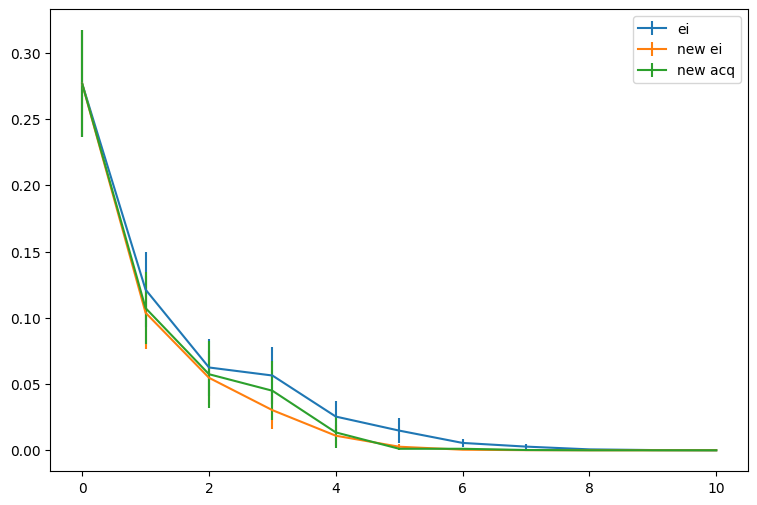

In [113]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)

myxaxis=range(regret_holder2.shape[1])

N =20
plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
plt.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='new ei')
plt.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='new acq')
plt.legend()

 /tmp/ipykernel_143016/3938385388.py:4: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_143016/3938385388.py:5: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_143016/3938385388.py:6: RuntimeWarning:divide by zero encountered in log


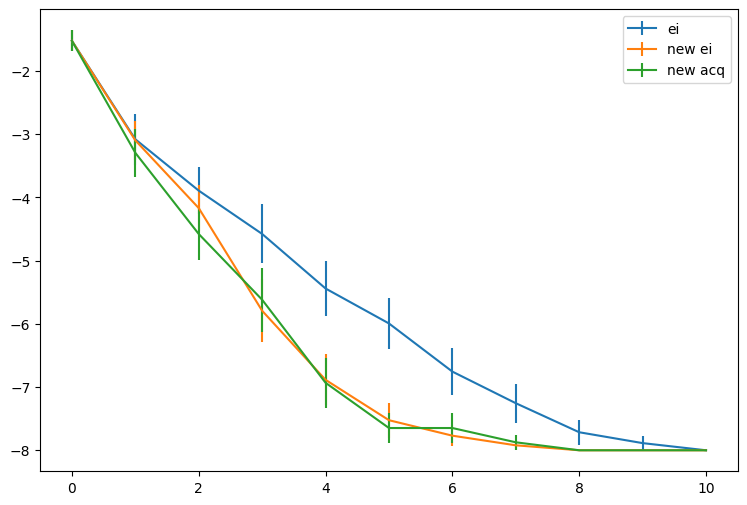

In [114]:
#myxaxis=range(a.shape[1])
N =20
myxaxis=range(regret_holder2.shape[1])
logregret_holder1_new = np.log(regret_holder1)
logregret_holder2_new = np.log(regret_holder2)
logregret_holder3_new = np.log(regret_holder3)


logregret_holder1_new[logregret_holder1_new == float('-inf')] = -8
logregret_holder2_new[logregret_holder2_new == float('-inf')] = -8
logregret_holder3_new[logregret_holder3_new == float('-inf')] = -8

plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(logregret_holder1_new,axis=0),np.std(logregret_holder1_new,axis=0)/np.sqrt(N),label='ei')
plt.errorbar(myxaxis,np.mean(logregret_holder2_new,axis=0),np.std(logregret_holder2_new,axis=0)/np.sqrt(N),label='new ei')
plt.errorbar(myxaxis,np.mean(logregret_holder3_new,axis=0),np.std(logregret_holder3_new,axis=0)/np.sqrt(N),label='new acq')

plt.legend()

In [69]:
np.savetxt('function2d_2_ei', regret_holder1, delimiter=',')
np.savetxt('function2d_2_new_ei', regret_holder2, delimiter=',')
np.savetxt('function2d_2_new_acq', regret_holder3, delimiter=',')

In [62]:
regret_holder4 = []


N = 20

for i in range(N):
  X_total, Y_total = My_Objective_Function()
  print(i)
  print('optimal: ',np.max(Y_total))

  regret_temp4 = paper_BO(X_total,Y_total,'ei',seed = i)
  regret_holder4.append(regret_temp4)


0
optimal:  6.096562626882651
optimum is  6.096562626882651
False
1
optimal:  6.096562626882651
optimum is  6.096562626882651
True
True
True
True
True
True
True
True
True
True
2
optimal:  6.096562626882651
optimum is  6.096562626882651
False
3
optimal:  6.096562626882651
optimum is  6.096562626882651
False
4
optimal:  6.096562626882651
optimum is  6.096562626882651
True
True
True
True
True
True
True
True
True
True
5
optimal:  6.096562626882651
optimum is  6.096562626882651
False
6
optimal:  6.096562626882651
optimum is  6.096562626882651
False
7
optimal:  6.096562626882651
optimum is  6.096562626882651
False
8
optimal:  6.096562626882651
optimum is  6.096562626882651
True
True
True
True
True
True
True
True
True
True
9
optimal:  6.096562626882651
optimum is  6.096562626882651
False
10
optimal:  6.096562626882651
optimum is  6.096562626882651
False
11
optimal:  6.096562626882651
optimum is  6.096562626882651
False
12
optimal:  6.096562626882651
optimum is  6.096562626882651
True
True
Tru

In [63]:
np.savetxt('function2d_erm', regret_holder4, delimiter=',')